In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/dynamics`


In [11]:
using ModelingToolkit
using OrdinaryDiffEq, DiffEqCallbacks
using ReferenceFrameRotations, LinearAlgebra
using StaticArrays
using Plots

## Naive method: Renormalize after each RK4 step (dtmin error)

In [138]:
function vectdquat(vq, ω)
    q = Quaternion(vq)
    dq = dquat(q, ω)
    return @SVector [dq[1], dq[2], dq[3], dq[4]]
end

@variables t (vq(t))[1:4]
@parameters ω[1:3]
@register vectdquat(vq, ω)
D = Differential(t)

eqs = [
    collect(D.(vq)[2:4] .~ vectdquat(vq, ω)[2:4])...
    0 ~ 1 - vq'*vq
]

@named att_prop = ODESystem(eqs)
tspan = (0.0, 1000.0)

prob = ODEProblem(
    att_prop,
    [vq[1] => 1.0, vq[2] => 0.0, vq[3] => 0.0, vq[4] => 0.0],
    tspan,
 [ω[1] => 0.05, ω[2] => 0.0, ω[3] => 0.0]
)

sol = solve(prob, Rosenbrock23(), reltol = 1e-8, abstol = 1e-8)
plot(sol)

┌ Warning: dt(1.1368683772161603e-13) <= dtmin(1.1368683772161603e-13) at t=818.4517268508253, and step error estimate = 80494.6101020022. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase ~/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


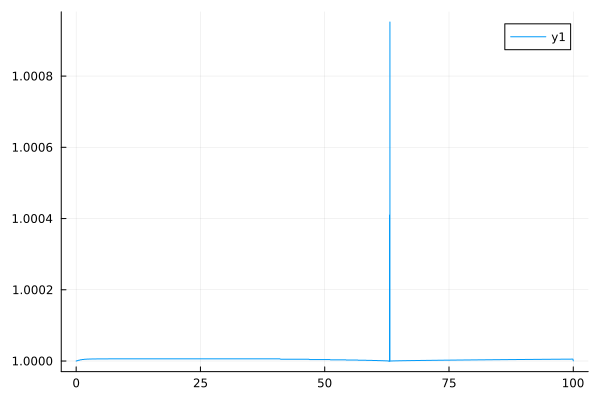

In [105]:
# check for constraint violation

temp = zeros(length(sol.t),1)

for i in 1:length(sol.t)
    q = sol[vq][i]
    temp[i] = q'*q
end

plot(sol.t, temp)

## Using manifold projection: too expensive

In [127]:
function vectdquat(vq, ω)
    q = Quaternion(vq)
    dq = dquat(q, ω)
    return @SVector [dq[1], dq[2], dq[3], dq[4]]
end

function g(resid,u,p,t)
  resid[1] = u'*u - 1
end

cb = ManifoldProjection(g)

@variables t (vq(t))[1:4]
@parameters ω[1:3]
@register vectdquat(vq, ω)

D = Differential(t)

eqs = [
    collect(D.(vq)[2:4] .~ vectdquat(vq, ω)[2:4])...
    0 ~ 1 - vq'*vq
]

@named att_prop = ODESystem(eqs)

prob = ODEProblem(
    att_prop,
    [vq[1] => 1.0, vq[2] => 0.0, vq[3] => 0.0, vq[4] => 0.0],
    (0.0, 100.0),
 [ω[1] => 0.05, ω[2] => 0.0, ω[3] => 0.0]
)

sol = solve(prob, Rosenbrock23(), reltol = 1e-8, abstol = 1e-8, callback = cb)
plot(sol)

LoadError: InterruptException:

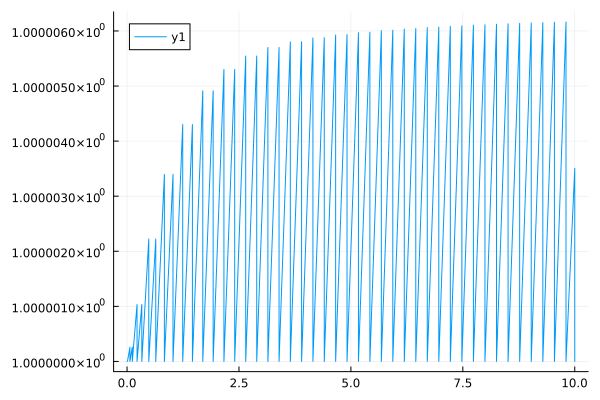

In [126]:
temp = zeros(length(sol.t),1)

for i in 1:length(sol.t)
    q = sol[vq][i]
    temp[i] = q'*q
end

plot(sol.t, temp)

## Normalization after each timestep

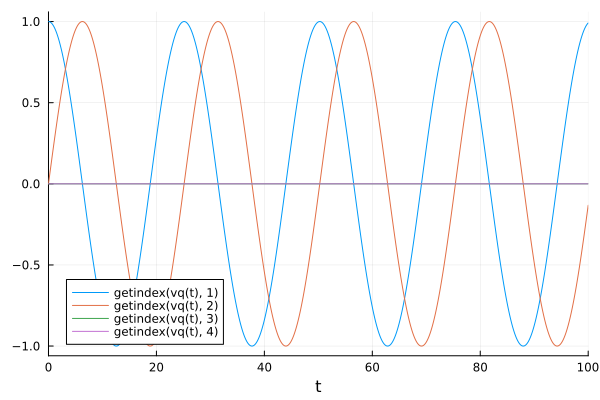

In [251]:
function vectdquat(vq, ω)
    q = Quaternion(vq)
    dq = dquat(q, ω)
    return @SVector [dq[1], dq[2], dq[3], dq[4]]
end

condition(u, t, integrator) = integrator.iter > 0

function affect!(integrator)
    integrator.u = integrator.u / norm(integrator.u)
end 

cb = DiscreteCallback(condition, affect!)

@variables t (vq(t))[1:4]
@parameters ω[1:3]
@register vectdquat(vq, ω)
D = Differential(t)

qdot = vectdquat(vq, ω)


eqs = [
    D(vq[1]) .~ qdot[1],
    D(vq[2]) .~ qdot[2],
    D(vq[3]) .~ qdot[3],
    D(vq[4]) .~ qdot[4]
]

@named att_prop = ODESystem(eqs)
tspan = (0.0, 100.0)

prob = ODEProblem(
    att_prop,
    [vq[1] => 1.0, vq[2] => 0.0, vq[3] => 0.0, vq[4] => 0.0],
    tspan,
 [ω[1] => 0.5, ω[2] => 0.0, ω[3] => 0.0]
)

sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, callback = cb)
plot(sol)

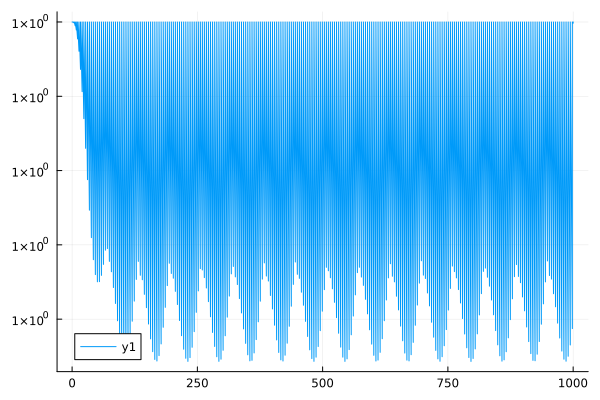

GKS: Possible loss of precision in routine SET_WINDOW


In [248]:
temp = zeros(length(sol.t),1)

for i in 1:length(sol.t)
    q = sol[vq][i]
    temp[i] = q'*q
end

plot(sol.t, temp)

## Quaternion exponential

In [3]:
function quat_exp(q)
    qw = q.q0
    qx = q.q1
    qy = q.q2
    qz = q.q3
    
    q_real_norm = norm(imag(q))
    
    qw_res = exp(qw) .* cos(q_real_norm)
    
    if iszero(q_real_norm)
        q_real_norm = 1.0
        print(q_real_norm)
    end 
    
    esinc = exp(qw) .* sin(q_real_norm) ./ q_real_norm
    
    qx_res = qx .* esinc
    qy_res = qy .* esinc
    qz_res = qz .* esinc

    return Quaternion(qw_res, qx_res, qy_res, qz_res)

end

quat_exp (generic function with 1 method)

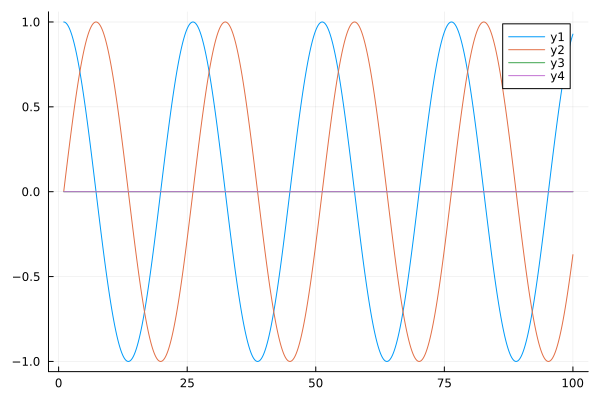

In [6]:
# to test quaternion exponential function

q = Quaternion(1,0,0,0)
ω = [0.5 0 0]
tspan = (1,100)
dt = 0.01

q0 = q

t = tspan[1]:dt:tspan[2]
q_vec = ones(length(t), 4)

for (i,timestep) in enumerate(t)
    q_exp = quat_exp(Quaternion(0, ω[1]*dt/2, ω[2]*dt/2, ω[3]*dt/2))
    q1 = q_exp*q0
    
    q_vec[i,1] = q1.q0
    q_vec[i,2] = q1.q1
    q_vec[i,3] = q1.q2
    q_vec[i,4] = q1.q3
    
    q0 = q1
end


plot(t, q_vec)

0.9999999996875  2.4999999997395832e-5  0.0  0.0
0.9999999687500002  0.0002499999973958333  0.0  0.0
0.9999968750016276  0.002499997395834146  0.0  0.0
0.9996875162757026  0.024997395914712322  0.0  0.0
0.9689124217106448  0.24740395925452283  0.0  0.0
-0.8011436155469327  0.5984721441039579  0.0  0.0
0.9912028118634717  -0.1323517500977871  -0.0  -0.0
-0.6742457601620054  0.7385070445862785  0.0  0.0


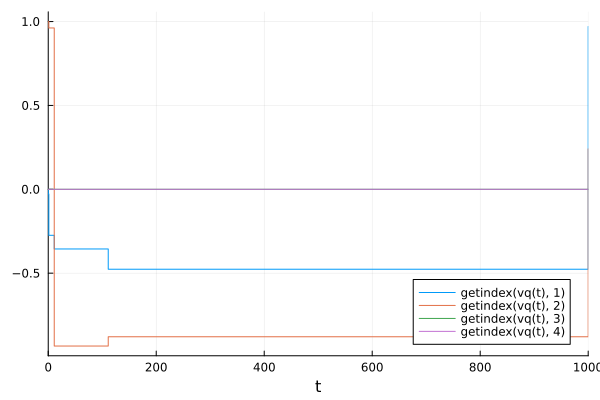

In [9]:
condition(u, t, integrator) = integrator.iter > 0

function affect!(integrator)
    dt = abs(integrator.t - integrator.tprev)
    ω = [0.5,0,0]
    
    qw = 0
    qx = ω[1]*dt/2
    qy = ω[2]*dt/2
    qz = ω[3]*dt/2
    
    q_real_norm = norm([qx qy qz])
    
    qw_res = exp(qw) .* cos(q_real_norm)
    esinc = exp(qw) .* sin(q_real_norm) ./ q_real_norm
    
    qx_res = qx .* esinc
    qy_res = qy .* esinc
    qz_res = qz .* esinc
    
    q1 = Quaternion(qw_res, qx_res, qy_res, qz_res)
    q0 = Quaternion(integrator.u[1], integrator.u[2],integrator.u[3],integrator.u[4])
    
    qdot = q1*q0
    set_u!(integrator, [qdot.q0 ,qdot.q1,qdot.q2,qdot.q3 ])
    
    integrator.u = integrator.u / norm(integrator.u)
    
    println(qw_res,"  ", qx_res,"  ", qy_res,"  ", qz_res)

    
end 

cb = DiscreteCallback(condition, affect!)

@variables t (vq(t))[1:4]
@parameters ω[1:3]
D = Differential(t)


eqs = [
    D(vq[1]) .~ 0,
    D(vq[2]) .~ 0,
    D(vq[3]) .~ 0,
    D(vq[4]) .~ 0
]

@named att_prop = ODESystem(eqs)
tspan = (0.0, 1000.0)

prob = ODEProblem(
    att_prop,
    [vq[1] => 0.0, vq[2] => 1.0, vq[3] => 0.0, vq[4] => 0.0],
    tspan,
 [ω[1] => 0.5, ω[2] => 0.0, ω[3] => 0.0]
)

sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, callback = cb, save_everystep=false)
plot(sol)

## Full attitude dynamics (just normalization)

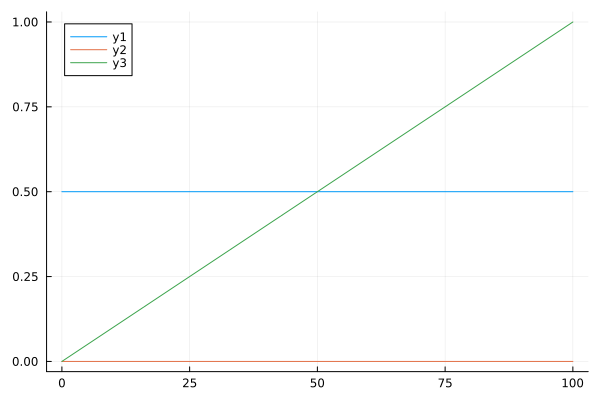

In [72]:
function vectdquat(vq, ω)
    q = Quaternion(vq)
    dq = dquat(q, ω)
    return @SVector [dq[1], dq[2], dq[3], dq[4]]
end

condition(u, t, integrator) = integrator.iter > 0

function affect!(integrator)
    
    u_current = integrator.u
    q = u_current[1:4]
    
    # normalize the quaternion
    q = q / norm(q)
    
    u_current[1:4] = q
    set_u!(integrator, u_current)
end 

cb = DiscreteCallback(condition, affect!)

@register vectdquat(vq, ω)
qdot = vectdquat(vq, ω)

@parameters J_11 J_12 J_13 J_21 J_22 J_23 J_31 J_32 J_33
@variables t ω_x(t) ω_y(t) ω_z(t) 
@variables τ_x(t)=0 [input=true] τ_y(t)=0 [input=true] τ_z(t)=0.01 [input=true]

D = Differential(t)

J = [J_11 J_12 J_13
     J_21 J_22 J_23
     J_31 J_32 J_33]

J = [J_11 0 0 
     0 J_22 0
     0 0 J_33]

ω = [ω_x, ω_y, ω_z]
τ = [τ_x, τ_y, τ_z]

# euler's law of rotation
ω̇ = inv(J) * (τ - cross(ω, J*ω))


eqs = [
    D(vq[1]) .~ qdot[1],
    D(vq[2]) .~ qdot[2],
    D(vq[3]) .~ qdot[3],
    D(vq[4]) .~ qdot[4],
    D(ω[1])  .~ ω̇[1],
    D(ω[2])  .~ ω̇[2],
    D(ω[3])  .~ ω̇[3],
]

@named att_prop = ODESystem(eqs)
att_prop = structural_simplify(att_prop)
    
tspan = (0.0, 100.0)

params = [
        J_11 => 1 ,
        J_12 => 0 ,
        J_13 => 0 ,
        J_21 => 0 ,
        J_22 => 1 ,
        J_23 => 0 ,
        J_31 => 0 ,
        J_32 => 0 ,
        J_33 => 1 ]

x_0 = [
    # intitial attitude as quaternion
    vq[1] => 1.0,
    vq[2] => 0.0,
    vq[3] => 0.0,
    vq[4] => 0.0,
    # initial angular velocity
    ω[1] => 0.5,
    ω[2] => 0.0,
    ω[3] => 0.0]

prob = ODEProblem(att_prop,x_0,tspan, params)

sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, callback = cb, save_everystep=false)
plot(sol.t, [sol[ω_x], sol[ω_y], sol[ω_z]])

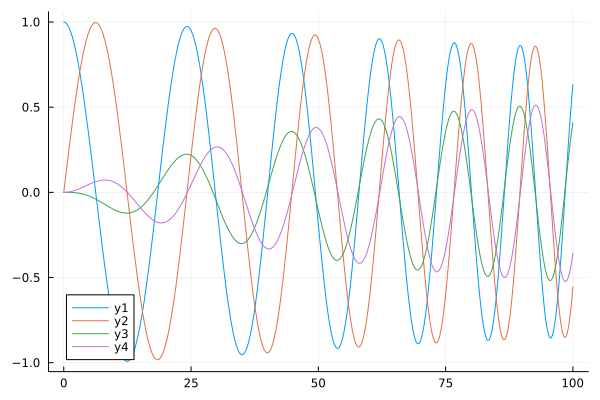

In [68]:
plot(sol.t, [sol[vq[1]] sol[vq[2]] sol[vq[3]] sol[vq[4]] ])

## Full attitude dynamics (Munthe-Haas + normalization)

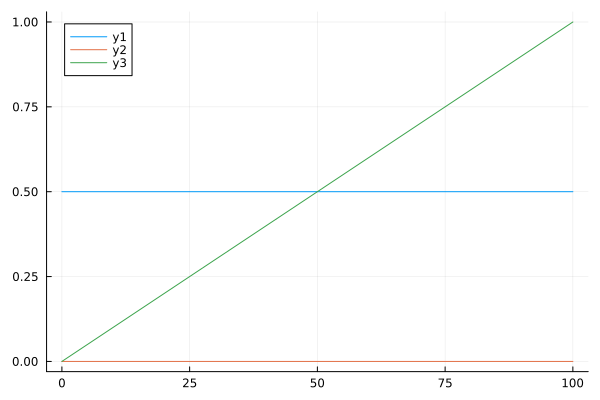

In [69]:
function vectdquat(vq, ω)
    q = Quaternion(vq)
    dq = dquat(q, ω)
    return @SVector [dq[1], dq[2], dq[3], dq[4]]
end

condition(u, t, integrator) = integrator.iter > 0

function affect!(integrator)
    dt = abs(integrator.t - integrator.tprev)
    
    q0_vals = integrator.uprev[1:4]
    ω_prev = integrator.uprev[5:7]
    
    q_exp = quat_exp(Quaternion(0, ω_prev[1]*dt/2, ω_prev[2]*dt/2, ω_prev[3]*dt/2))
    q0 = Quaternion(q0_vals[1], q0_vals[2], q0_vals[3], q0_vals[4])
    
    q1 = q_exp*q0
    q1 = q1 / norm(q1)
    
    integrator.u[1:4] = [q1.q0 q1.q1 q1.q2 q1.q3]
end 

cb = DiscreteCallback(condition, affect!)

@register vectdquat(vq, ω)
qdot = vectdquat(vq, ω)

@parameters J_11 J_12 J_13 J_21 J_22 J_23 J_31 J_32 J_33
@variables t ω_x(t) ω_y(t) ω_z(t) 
@variables τ_x(t)=0 [input=true] τ_y(t)=0 [input=true] τ_z(t)=0.01 [input=true]

D = Differential(t)

J = [J_11 J_12 J_13
     J_21 J_22 J_23
     J_31 J_32 J_33]

J = [J_11 0 0 
     0 J_22 0
     0 0 J_33]

ω = [ω_x, ω_y, ω_z]
τ = [τ_x, τ_y, τ_z]

# euler's law of rotation
ω̇ = inv(J) * (τ - cross(ω, J*ω))

eqs = [
    D(vq[1]) .~ qdot[1],
    D(vq[2]) .~ qdot[2],
    D(vq[3]) .~ qdot[3],
    D(vq[4]) .~ qdot[4],
    D(ω[1])  .~ ω̇[1],
    D(ω[2])  .~ ω̇[2],
    D(ω[3])  .~ ω̇[3],
]


@named att_prop = ODESystem(eqs)
att_prop = structural_simplify(att_prop)
    
tspan = (0.0, 100.0)

params = [
        J_11 => 1 ,
        J_12 => 0 ,
        J_13 => 0 ,
        J_21 => 0 ,
        J_22 => 1 ,
        J_23 => 0 ,
        J_31 => 0 ,
        J_32 => 0 ,
        J_33 => 1 ]

x_0 = [
    vq[1] => 1.0,
    vq[2] => 0.0,
    vq[3] => 0.0,
    vq[4] => 0.0,
    ω[1] => 0.5,
    ω[2] => 0.0,
    ω[3] => 0.0]

prob = ODEProblem(att_prop,x_0,tspan, params)

sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, callback = cb)
plot(sol.t, [sol[ω_x], sol[ω_y], sol[ω_z]])

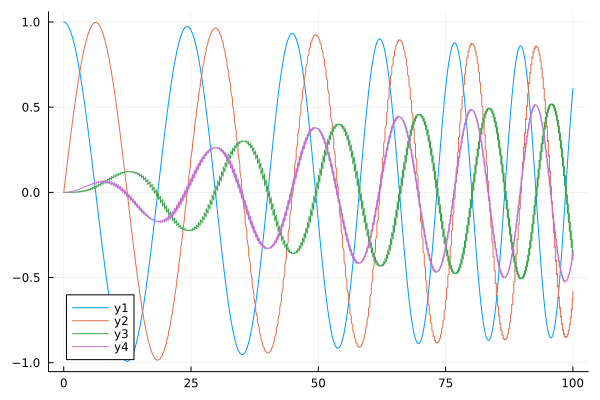

In [70]:
plot(sol.t, [sol[vq[1]] sol[vq[2]] sol[vq[3]] sol[vq[4]] ])